In [80]:
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import numpy as np
import random 

In [81]:
G = nx.Graph()

In [82]:
artists = {}

for artist in pd.read_csv('artists.csv').iterrows():
    data = list(artist)[1]
    artists[data['id']] = data['name']
    G.add_node(data['name'], role = 'artist', bipartite = 1)

In [83]:
for userArtist in pd.read_csv('users-artists.csv').iterrows():
    data = list(userArtist)[1]
    
    if not G.has_node(data['userID']):
        G.add_node(data['userID'], role = 'user', bipartite = 1)

    if not G.has_edge(data['userID'], artists[data['artistID']]):
        G.add_edge(data['userID'], artists[data['artistID']], weight = data['weight'])

In [84]:
print("No of nodes:", len(G.nodes))
print("No of edges:", len(G.edges))

No of nodes: 19524
No of edges: 92834


In [85]:
users = list(filter(lambda node: G.nodes[node]['role'] == 'user', list(G.nodes())))

print("No of users:", len(users))
print("No of artists:", len(artists))

No of users: 1892
No of artists: 17632


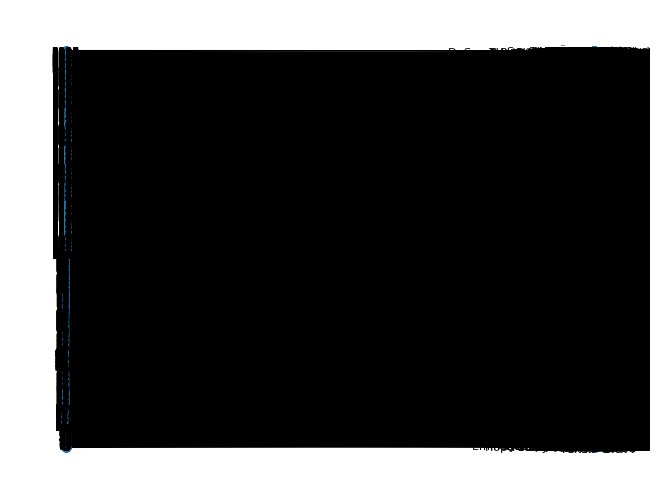

In [ ]:
pos = nx.bipartite_layout(G, users) 
nx.draw(G, pos, with_labels = True, node_size = 40, font_size = 8)

In [122]:
class JaccardMeasure:
    def __init__(self, graph):
        self.graph = graph   

    def average_weight(self, graph = None):
        if graph == None:
            graph = self.graph 

        count = 0
        totalWeight = 0

        for edge in graph.edges.data():
            count = count + 1
            totalWeight = totalWeight + edge[2]['weight']

        return totalWeight // count 

    def jaccard_measure(self, graph = None):
        if graph == None:
            graph = self.graph 

        predictedEdges = []
        avgWeight = self.average_weight(graph)

        for i in graph.nodes():
            adjList1 = [neighbour for neighbour in graph[i]]
            dict = {}

            for j in graph.nodes():
                if not i == j:
                    adjList2 = [neighbour for neighbour in graph[j]]

                    total = len(adjList1) + len(adjList2)
                    common = len(list(set(adjList1) & set(adjList2)))

                    if not total == 0:
                        jaccard_score = common / total 
                        dict[j] = jaccard_score

            keys = list(dict.keys())
            values = list(dict.values())
            sorted_value_index = np.argsort(values)
            dict = {keys[x]: values[x] for x in sorted_value_index}

            if not len(dict) == 0:
                temp = {}

                for neighbour, properties in graph[list(dict)[-1]].items():
                    if properties['weight'] >= avgWeight:
                        temp[neighbour] = properties['weight']

                keys = list(temp.keys())
                values = list(temp.values())
                sorted_value_index = np.argsort(values)
                temp = {keys[x]: values[x] for x in sorted_value_index}

                if not len(temp) == 0:
                    topNeighbours = []
                    k = len(temp) - 1
                    count = 0

                    while k > 0 and k < len(temp):
                        if count > 11:
                            break

                        topNeighbours.append(list(temp)[k])
                        k = k - 1
                        count = count + 1

                    results = list(set(topNeighbours).difference(set(adjList1)))

                    for result in results:
                        if (result, i) not in predictedEdges:
                            predictedEdges.append((i, result))   

        return predictedEdges

    def score(self):
        edges = list(self.graph.edges.data())
        no_of_test_edges = int(len(edges) * 0.2)
        test_edges = []

        for i in range(0, no_of_test_edges + 1):
            test_edges.append(edges[i])

        test_graph = nx.Graph()
        temp_graph = nx.Graph()

        for edge in test_edges:
            test_graph.add_edge(edge[0], edge[1], weight = edge[2]['weight'])
            temp_graph.add_edge(edge[0], edge[1], weight = edge[2]['weight'])

        for i in range(1, 200):
            edge = test_edges[random.randint(0, len(test_edges))]

            if temp_graph.has_edge(edge[0], edge[1]):
                temp_graph.remove_edge(edge[0], edge[1])   

        actual = test_edges
        predicted = self.jaccard_measure(temp_graph)

        TP = len(actual) + len(predicted)
        FP = 0
        FN = 0

        for edge in actual:
            if not edge in predicted:
                FP = FP + 1

        for edge in predicted: 
            if not edge in actual:
                FN = FN + 1

        return TP / (TP + 0.5 * (FP + FN))

In [ ]:
jacc = JaccardMeasure(G)

predictedLinks = jacc.jaccard_measure()
print("Predicted Links:", predictedLinks)

Predicted Links: [('Marilyn Manson', 546), ('Marilyn Manson', 388), ('Marilyn Manson', 909), ('Marilyn Manson', 903), ('DIR EN GREY', 76), ('Combichrist', 1604), ('Combichrist', 1973), ('Dimmu Borgir', 595), ('Dimmu Borgir', 1924), ('And One', 1505), ('And One', 455), ('And One', 1454), ('And One', 371), ('And One', 951), ('And One', 446), ('KMFDM', 1107), ('Mindless Self Indulgence', 1450), ('Mindless Self Indulgence', 1418), ('Mindless Self Indulgence', 356), ('Mindless Self Indulgence', 1741), ('Duran Duran', 780), ('Duran Duran', 850), ('Duran Duran', 1173), ('Duran Duran', 1942), ('Duran Duran', 831), ('Air', 1793), ('Air', 1470), ('Air', 455), ('Air', 1899), ('Air', 396), ('Air', 919), ('Air', 601), ('Air', 698), ('Air', 1438), ('Hooverphonic', 1280), ('Hooverphonic', 455), ('Hooverphonic', 874), ('Hooverphonic', 2096), ('Hooverphonic', 1752), ('Kylie Minogue', 514), ('Kylie Minogue', 2059), ('Kylie Minogue', 684), ('Kylie Minogue', 1072), ('Kylie Minogue', 691), ('Kylie Minogue'

In [109]:
accuracy = jacc.score()
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


In [131]:
G.add_edges_from(predictedLinks, weight = 1)

In [135]:
G.add_node(8888, role = 'user')

for i in range(1, 6):
    artistIdx = random.randint(0, len(artists))           
    G.add_edge(8888, artists[list(artists.keys())[artistIdx]], weight = 1)

print([(8888, edge) for edge in G[8888]])

[(8888, 'A Kid Hereafter'), (8888, 'Spektre'), (8888, 'The Blizzard'), (8888, 'Filippa Giordano'), (8888, 'Gina Rene, Gabriel Rene, Lindsay Lohan, Rachel McAdams, Lacey Chabert, & Amanda Seyfried')]


In [136]:
jacc2 = JaccardMeasure(G)
newLinks = jacc2.jaccard_measure()
print("New Links:", newLinks)

New Links: [('Combichrist', 516), ('London After Midnight', 777), ('The Crüxshadows', 40), ('The Crüxshadows', 1929), ('Covenant', 1929), ('Covenant', 874), ('Covenant', 729), ('KMFDM', 1973), ('Duran Duran', 442), ('Duran Duran', 932), ('Duran Duran', 1246), ('Morcheeba', 831), ('Morcheeba', 1223), ('Faithless', 606), ('Icehouse', 187), ('Dido', 1736), ('Dido', 1456), ('Dido', 1909), ('Dido', 1973), ('Dido', 252), ('Dido', 350), ('Dido', 159), ('Camouflage', 951), ('Camouflage', 850), ('Camouflage', 455), ('Electronic', 1202), ('Groove Armada', 670), ('Groove Armada', 1910), ('Cut Copy', 387), ('Cut Copy', 1075), ('Cut Copy', 1054), ('Cut Copy', 2010), ('Cut Copy', 1470), ('Jean-Michel Jarre', 1929), ('Japan', 2052), ('Burial', 697), ('Burial', 1740), ('Burial', 1005), ('Burial', 2006), ('De/Vision', 2080), ('De/Vision', 442), ('De/Vision', 2), ('Robbie Williams', 732), ('Robbie Williams', 1300), ('Robbie Williams', 1909), ('Robbie Williams', 1973), ('Robbie Williams', 380), ('The Cra

In [137]:
result = []

for link in newLinks:
    if link[0] == 8888 or link[1] == 8888:
        result.append(link)

print(result)

[]
